In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sandhyavanisadineni","key":"d0a854f5331739b6a509eb02e13ebb17"}'}

In [ ]:
!mkdir ~/.kaggle/

In [ ]:

!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dogs-vs-cats

 99% 808M/812M [00:20<00:00, 43.4MB/s]
100% 812M/812M [00:20<00:00, 40.8MB/s]


In [ ]:
!unzip -qq dogs-vs-cats.zip

In [ ]:
!unzip -qq train.zip

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_1")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          12,545 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

It is evident that the model might overfit, so we apply regularization techniques during the data preprocessing stage. At this point, all images are converted into tensors.

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Callbacks can be used to save the model's weights after each epoch or to stop training early if there is no improvement. They can also be utilized to log metrics, visualize the model's performance, or adjust the learning rate on a schedule.

In [ ]:
from tensorflow import keras
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch1.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 160ms/step - accuracy: 0.5501 - loss: 0.7011 - val_accuracy: 0.5010 - val_loss: 0.6919
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.5254 - loss: 0.7166 - val_accuracy: 0.6370 - val_loss: 0.6853
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.5697 - loss: 0.6906 - val_accuracy: 0.6330 - val_loss: 0.6672
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.5923 - loss: 0.6790 - val_accuracy: 0.6370 - val_loss: 0.6553
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.6297 - loss: 0.6500 - val_accuracy: 0.5650 - val_loss: 0.7867
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.6829 - loss: 0.6114 - val_accuracy: 0.7120 - val_loss: 0.5567
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.7299 - loss: 0.5651 - val_accuracy: 0.7350 - val_loss: 0.5487
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.7589 - loss: 0.5121 - val_accuracy: 0.6990 -

It can be observed that as the number of epochs increases, the accuracy improves.

Accuracy: 78.2%, Validation accuracy: 73.60, Test accuracy: 54.42%.

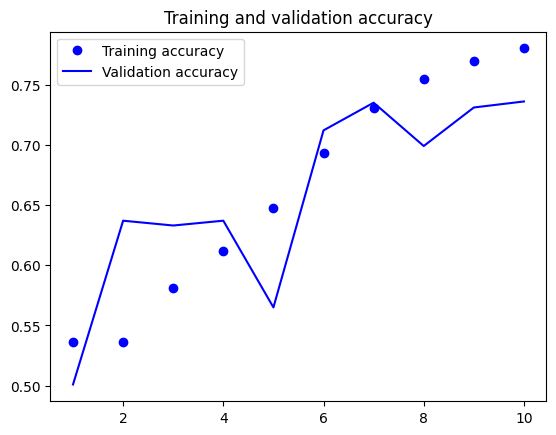

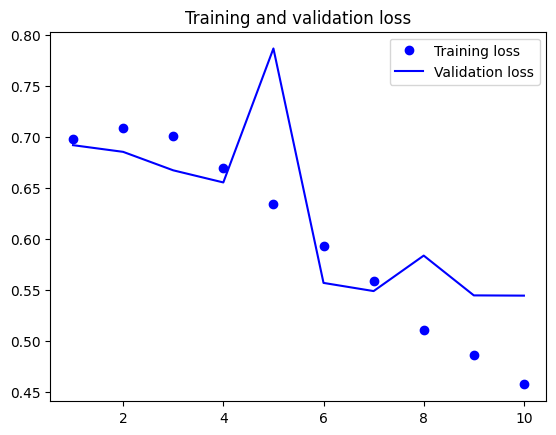

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch1.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.7100 - loss: 0.5753
Test accuracy: 0.701


Test accuracy without data augmentation=70.1%

**Data Augmentation**

"Data augmentation" creates modified versions of the original data to increase the size of the training set. This helps improve the model's generalization ability and reduces the risk of overfitting.

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)


In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation1.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - accuracy: 0.4981 - loss: 0.7154 - val_accuracy: 0.5030 - val_loss: 0.6930
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.4995 - loss: 0.6941 - val_accuracy: 0.5610 - val_loss: 0.6914
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.5045 - loss: 0.6920 - val_accuracy: 0.5440 - val_loss: 0.6856
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.5425 - loss: 0.6895 - val_accuracy: 0.5300 - val_loss: 0.6803
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.5720 - loss: 0.6850 - val_accuracy: 0.6040 - val_loss: 0.7000
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.6036 - loss: 0.6556 - val_accuracy: 0.6640 - val_loss: 0.6055
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.6381 - loss: 0.6337 - val_accuracy: 0.6520 - val_loss: 0.6145
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.6591 - loss: 0.6237 - val_accuracy: 0.6100 -

Applying data augmentation to the model did not yield improved results. However, this can be further tested by increasing the training sample size and experimenting with data augmentation on the larger dataset.

Accuracy: 69.6%, Validation accuracy: 65.40%, Test accuracy: 60.87%.

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation1.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6471 - loss: 0.6099
Test accuracy: 0.671


**2)Increase training sample size**

Tried by increasing training sample size from 1000 to 1500.

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_2")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2000)
make_subset("test", start_index=2000, end_index=2500)

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 3000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch2.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - accuracy: 0.5252 - loss: 0.7063 - val_accuracy: 0.6190 - val_loss: 0.6892
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.5523 - loss: 0.6879 - val_accuracy: 0.6220 - val_loss: 0.6454
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.6396 - loss: 0.6431 - val_accuracy: 0.6250 - val_loss: 0.6419
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.6905 - loss: 0.6023 - val_accuracy: 0.6980 - val_loss: 0.5774
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.7044 - loss: 0.5803 - val_accuracy: 0.6940 - val_loss: 0.5779
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.7275 - loss: 0.5556 - val_accuracy: 0.6750 - val_loss: 0.7332
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.7643 - loss: 0.4982 - val_accuracy: 0.7430 - val_loss: 0.5386
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.7879 - loss: 0.4646 - val_accuracy: 0.7300 -

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch2.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.7774 - loss: 0.5152
Test accuracy: 0.778


Accuracy=77.8% val_acc=75.0% test_acc=77.8%

**Using data augmentation**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation2.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - accuracy: 0.5220 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6936
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.5197 - loss: 0.6936 - val_accuracy: 0.5150 - val_loss: 0.6871
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.5368 - loss: 0.6854 - val_accuracy: 0.5320 - val_loss: 0.6878
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.5361 - loss: 0.6852 - val_accuracy: 0.5750 - val_loss: 0.6720
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.6158 - loss: 0.6546 - val_accuracy: 0.6240 - val_loss: 0.6576
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.6411 - loss: 0.6300 - val_accuracy: 0.6480 - val_loss: 0.6430
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.6629 - loss: 0.6307 - val_accuracy: 0.6710 - val_loss: 0.6080
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.6791 - loss: 0.6074 - val_accuracy: 0.6460 - 

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation2.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.7401 - loss: 0.5462
Test accuracy: 0.737


Accuracy=74.01% val_acc=70.5% test_acc=73.7%

**3. Finding the ideal training sample size**

We set the training, validation, and test set sizes, respectively, to 1500, 1000, and 500.

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2500)
make_subset("test", start_index=2500, end_index=3000)

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)


Found 3000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch3.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - accuracy: 0.5088 - loss: 0.7193 - val_accuracy: 0.5060 - val_loss: 0.6915
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.5612 - loss: 0.6893 - val_accuracy: 0.6465 - val_loss: 0.6534
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.6129 - loss: 0.6529 - val_accuracy: 0.6745 - val_loss: 0.6072
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.6713 - loss: 0.6240 - val_accuracy: 0.6925 - val_loss: 0.5976
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.6846 - loss: 0.5784 - val_accuracy: 0.7015 - val_loss: 0.5887
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.7352 - loss: 0.5376 - val_accuracy: 0.7075 - val_loss: 0.5792
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.7543 - loss: 0.4945 - val_accuracy: 0.7365 - val_loss: 0.5209
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.7907 - loss: 0.4384 - val_accuracy: 0.720

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch3.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7211 - loss: 0.5627
Test accuracy: 0.721


Accuracy=72.11% val_Acc=72.9% test_Acc=72.1%

**Using Data augmentation**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation3.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)


Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - accuracy: 0.5173 - loss: 0.6951 - val_accuracy: 0.5040 - val_loss: 0.6876
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.5570 - loss: 0.6806 - val_accuracy: 0.6580 - val_loss: 0.6414
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.6517 - loss: 0.6376 - val_accuracy: 0.6320 - val_loss: 0.6531
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.6321 - loss: 0.6474 - val_accuracy: 0.6310 - val_loss: 0.6478
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - accuracy: 0.6574 - loss: 0.6252 - val_accuracy: 0.6650 - val_loss: 0.6147
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.6802 - loss: 0.5954 - val_accuracy: 0.6700 - val_loss: 0.5966
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.6880 - loss: 0.5882 - val_accuracy: 0.7000 - val_loss: 0.5799
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.7173 - loss: 0.5656 - val_accuracy: 0.6990 -

In [ ]:

test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation3.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7224 - loss: 0.5776
Test accuracy: 0.703


Accuracy=72.24% val_acc=73.20% test_acc=70.3%

**4.Using a pre-trained network**

VGG16 is the architecture of this pre-trained network.

Feature extraction - Instantiating the VGG16 convolutional base

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))
conv_base.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 180, 180, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 90, 90, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 22, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 5, 5, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Feature extraction - Extracting features and corresponding labels

In [ ]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

train_features.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

(3000, 5, 5, 512)

Feature extraction is the process of defining and training a highly connected classifier.

In [ ]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extractionPT1.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=15,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.8913 - loss: 40.4274 - val_accuracy: 0.9620 - val_loss: 7.3736
Epoch 2/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9782 - loss: 2.7300 - val_accuracy: 0.9705 - val_loss: 5.0671
Epoch 3/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9878 - loss: 1.6456 - val_accuracy: 0.9730 - val_loss: 4.6013
Epoch 4/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9874 - loss: 1.3278 - val_accuracy: 0.9745 - val_loss: 5.8498
Epoch 5/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9955 - loss: 0.5052 - val_accuracy: 0.9730 - val_loss: 4.6522
Epoch 6/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9937 - loss: 0.5161 - val_accuracy: 0.9760 - val_loss: 4.7744
Epoch 7/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9953 - loss: 0.4115 - val_accuracy: 0.9775 - val_loss: 5.2999
Epoch 8/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9972 - loss: 0.1884 - val_accuracy: 0.9765 - val_los

accuracy=99.78% val_acc=97.65%

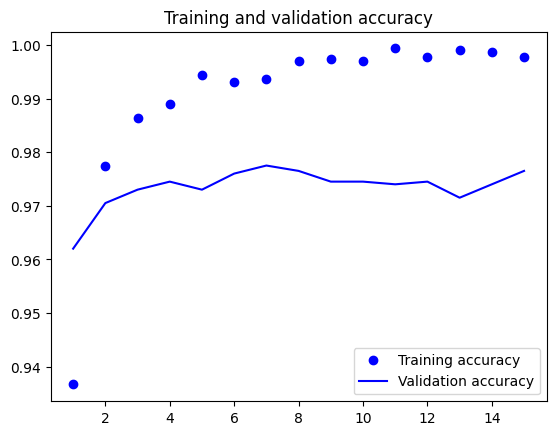

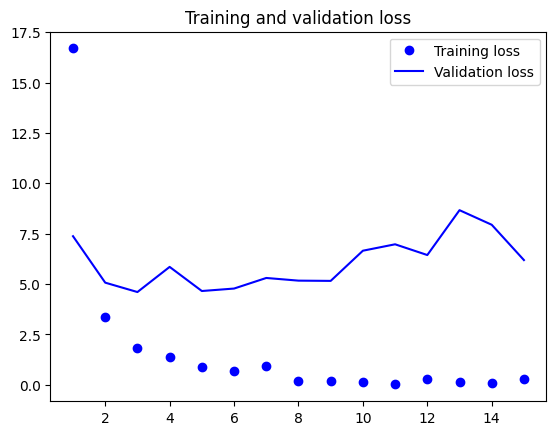

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False


conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))


conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))


This is the number of trainable weights before freezing the conv base: 26
This is the number of trainable weights after freezing the conv base: 0


**Feature extraction with Data Augmentation**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentationPT2.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=validation_dataset,
    callbacks=callbacks)


Epoch 1/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 25s 223ms/step - accuracy: 0.8550 - loss: 24.0386 - val_accuracy: 0.9735 - val_loss: 3.8942
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 34s 176ms/step - accuracy: 0.9423 - loss: 7.4619 - val_accuracy: 0.9725 - val_loss: 4.2034
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 189ms/step - accuracy: 0.9641 - loss: 4.6890 - val_accuracy: 0.9735 - val_loss: 3.4640
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 183ms/step - accuracy: 0.9657 - loss: 3.9598 - val_accuracy: 0.9770 - val_loss: 2.9135
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 184ms/step - accuracy: 0.9646 - loss: 3.1182 - val_accuracy: 0.9785 - val_loss: 2.7311


In [ ]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentationPT2.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9706 - loss: 4.6752
Test accuracy: 0.971


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Accuracy=97.06% val_Acc=97.85% test_acc=97.1%

In [ ]:
%%shell
jupyter nbconvert --to html /%%shell
jupyter nbconvert --to html //Untitled0.ipynb

[NbConvertApp] WARNING | pattern '/%%shell' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute 